# Environmetal sound classification


<a href="https://colab.research.google.com/github/GianmarcoLattaruolo/Vision_Project/blob/main/Vision_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading the data

Run this cell once to download the dataset.


In [3]:
import os
import shutil
import urllib
import zipfile
import glob
import urllib.request

def download_dataset(name):
    if not os.path.exists(f'./data'):
        os.mkdir('data')
    os.chdir('./data')
    """Download the dataset into current working directory.
    The labeled dataset is ESC-50, the unlabeld are ESC-US-00,ESC-US-01, ... , ESC-US-25 
    but I'm not able to download them automatically from https://dataverse.harvard.edu/dataverse/karol-piczak?q=&types=files&sort=dateSort&order=desc&page=1"""

    if name=='ESC-50' and not os.path.exists(f'./{name}'):

        if not os.path.exists(f'./{name}-master.zip') and not os.path.exists(f'./{name}-master'):
            urllib.request.urlretrieve(f'https://github.com/karoldvl/{name}/archive/master.zip', f'{name}-master.zip')

        if not os.path.exists(f'./{name}-master'):
            with zipfile.ZipFile(f'{name}-master.zip','r') as package:
                package.extractall(f'{name}-master')

        os.remove(f'{name}-master.zip') 
        original = f'./{name}-master/{name}-master/audio'
        target = f'./{name}'
        shutil.move(original,target)
        original = f'./{name}-master/{name}-master/meta'
        target = f'./meta'
        shutil.move(original,target)

    if os.path.exists(f'./{name}-master'):
        shutil.rmtree(f'./{name}-master')

    else:
        print('donwload it from https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/YDEPUT/YE0CVE&version=2.0#')
        pass 
    os.chdir('../')


download_dataset('ESC-50')


## Exploratory analysis

In this cell we can listen to one random audio in our dataset (different every time we run the cell). 
Moreover we visualize a portion of the audio.



3-144510-A-30.wav
44100
<class 'numpy.ndarray'>
(220500,)

44100
<class 'numpy.ndarray'>
(220500,)


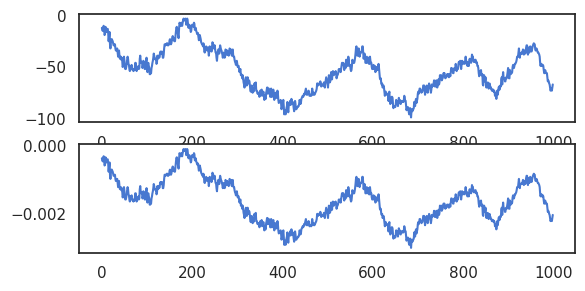

In [25]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import librosa
from scipy.io import wavfile
import seaborn as sb
sb.set(style="white", palette="muted")
import pandas as pd
import IPython.display
import random

os.chdir('/content/data/ESC-50')
audio_files  = os.listdir()
i = random.randint(0,len(audio_files))
clip = audio_files[i]
samplerate, data = wavfile.read(clip) # or alternatively
y,sr = librosa.load(clip,sr=samplerate)
#samplerate * seconds_clip_audio = length_np_array

print(clip)
print(samplerate)
print(type(data))
print(np.shape(data))
print('')
print(sr)
print(type(y))
print(np.shape(y))


display(IPython.display.Audio(data = data, rate=samplerate)  )
display(IPython.display.Audio(data = y, rate=samplerate)  )
plt.subplot(3,1,1)
plt.plot(data[:1000])
plt.subplot(3,1,2)
plt.plot(y[:1000])

os.chdir('/content')

Let's see a periodogram (power spectrum) for our clip.

Text(0.5, -0.41666666666667673, 'frequency [1/second]')

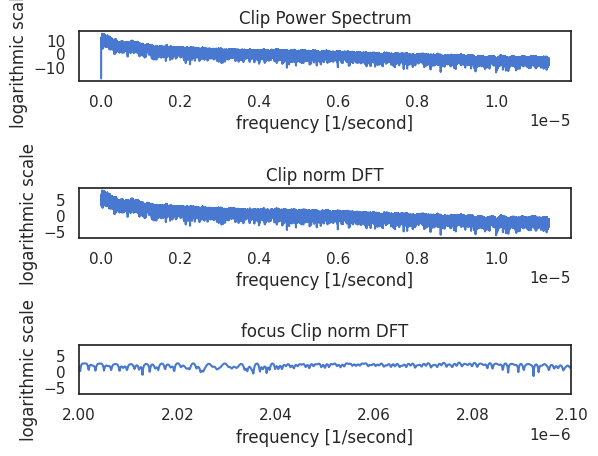

In [30]:
from scipy import signal
from scipy.fft import fft,ifft

fs=1/sr
n=len(y)
freq_y, pow_spect_y = signal.periodogram(y,fs=fs)
#it's better to make a logarithmic plot
log_pow_spec = np.log(pow_spect_y)

plt.subplot(3,1,1)
plt.plot(freq_y,log_pow_spec)
plt.title('Clip Power Spectrum')
plt.ylabel('logarithmic scale')
plt.xlabel('frequency [1/second]')
#it's difficult to carry out a significative graph

signal_hat = fft(y)
freq_x = np.asarray([fs/n*(i+1) for i in range(n)])
norm_signal_hat = np.absolute(signal_hat)
log_signal_hat = np.log(norm_signal_hat)
plt.subplot(3,1,2)
plt.tight_layout(pad=2)
plt.plot(freq_x[:n//2],log_signal_hat[:n//2])
plt.title('Clip norm DFT')
plt.ylabel('logarithmic scale')
plt.xlabel('frequency [1/second]')

plt.subplot(3,1,3)
plt.tight_layout(pad=2)
plt.plot(freq_x[:n//2],log_signal_hat[:n//2])
plt.xlim([0.2*1e-5, 0.21*1e-5])
plt.title('focus Clip norm DFT')
plt.ylabel('logarithmic scale')
plt.xlabel('frequency [1/second]')


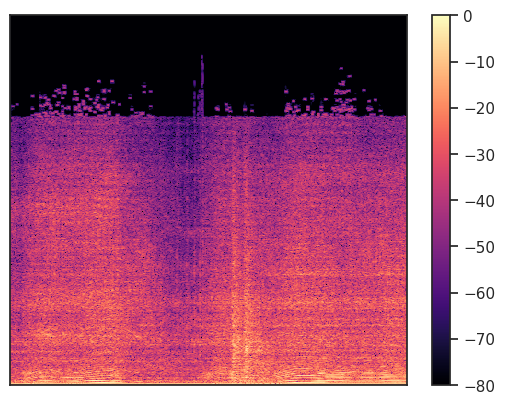

In [5]:
fig, ax = plt.subplots()
D = librosa.stft(y)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
img = librosa.display.specshow(data=S_db, sr=sr,ax=ax)
fig.colorbar(img, ax=ax)



## Auxiliary Classes

In [ ]:

class Clip():
    """A single 5-sec long recording."""
    
    samplerate = 44100   # All recordings in ESC are 44.1 kHz
    frame = 512    # Frame size in samples
    
    def __init__(self, path):
        self.path = path
        y,sr = librosa.load(self.path,sr=samplerate)
        self.raw = y
        

    #cosa vogliamo che faccia la classe che fa il load della singola clip audio?
